In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from Ctorch import *
from functions import *
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.signal import fftconvolve
from skimage import io
%matplotlib inline

/Volumes/Home/ys_koshelev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
a = io.imread('data/example2.png');
a_torch = torch.FloatTensor(a).unsqueeze(0).unsqueeze(0);
k = np.loadtxt('data/example2.dlm');
k_torch = torch.FloatTensor(k).unsqueeze(0).unsqueeze(0);

In [14]:
a_torch = a_torch.squeeze(1).permute(0,3,1,2);
a_torch.shape

torch.Size([1, 3, 700, 924])

# Standard data type: batches of shape NxCxHxWx2

In [52]:
def wrap_boundary_liu(img, img_size):

    """
    Reducing boundary artifacts in image deconvolution
    Renting Liu, Jiaya Jia
    ICIP 2008
    """
    (H,W) = np.shape(img);
    H_w = img_size[0] - H;
    W_w = img_size[1] - W;

    #ret = np.zeros((img_size[0], img_size[1]));
    alpha = 1;
    HG = img[:,:];

    r_A = np.zeros((alpha*2+H_w,W));
    r_A[:alpha,:] = HG[-alpha:,:];
    r_A[-alpha:,:] = HG[:alpha,:];
    a = np.arange(H_w)/(H_w-1);
    #r_A(alpha+1:end-alpha, 1) = (1-a)*r_A(alpha,1) + a*r_A(end-alpha+1,1);
    r_A[alpha:-alpha,0] = (1-a)*r_A[alpha-1,0] + a*r_A[-alpha,0];
    #r_A(alpha+1:end-alpha, end) = (1-a)*r_A(alpha,end) + a*r_A(end-alpha+1,end);
    r_A[alpha:-alpha, -1] = (1-a)*r_A[alpha-1,-1] + a*r_A[-alpha,-1];
    
    r_B = np.zeros((H, alpha*2+W_w));
    r_B[:, :alpha] = HG[:, -alpha:];
    r_B[:, -alpha:] = HG[:, :alpha];
    a = np.arange(W_w)/(W_w-1);
    r_B[0, alpha:-alpha] = (1-a)*r_B[0,alpha-1] + a*r_B[0,-alpha];
    r_B[-1, alpha:-alpha] = (1-a)*r_B[-1,alpha-1] + a*r_B[-1,-alpha];
    
    if alpha == 1:
        A2 = solve_min_laplacian(r_A[alpha-1:,:]);
        B2 = solve_min_laplacian(r_B[:,alpha-1:]);
        r_A[alpha-1:,:] = A2;
        r_B[:,alpha-1:] = B2;
    else:
        A2 = solve_min_laplacian(r_A[alpha-1:-alpha+1,:]);
        r_A[alpha-1:-alpha+1,:] = A2;
        B2 = solve_min_laplacian(r_B[:,alpha-1:-alpha+1]);
        r_B[:,alpha-1:-alpha+1] = B2;
    A = r_A;
    B = r_B;

    r_C = np.zeros((alpha*2+H_w, alpha*2+W_w));
    r_C[:alpha, :] = B[-alpha:, :];
    r_C[-alpha:, :] = B[:alpha, :];
    r_C[:, :alpha] = A[:, -alpha:];
    r_C[:, -alpha:] = A[:, :alpha];

    if alpha == 1:
        C2 = C2 = solve_min_laplacian(r_C[alpha-1:, alpha-1:]);
        r_C[alpha-1:, alpha-1:] = C2;
    else:
        C2 = solve_min_laplacian(r_C[alpha-1:-alpha+1, alpha-1:-alpha+1]);
        r_C[alpha-1:-alpha+1, alpha-1:-alpha+1] = C2;
    C = r_C;
    #return C;
    A = A[alpha-1:-alpha-1, :];
    B = B[:, alpha:-alpha];
    C = C[alpha:-alpha, alpha:-alpha];
    ret = np.vstack((np.hstack((img,B)),np.hstack((A,C))));
    return ret;

def solve_min_laplacian(boundary_image):
    (H,W) = np.shape(boundary_image);

    # Laplacian
    f = np.zeros((H,W));
    # boundary image contains image intensities at boundaries
    boundary_image[1:-1, 1:-1] = 0;
    j = np.arange(2,H)-1;      
    k = np.arange(2,W)-1;      
    f_bp = np.zeros((H,W));
    f_bp[np.ix_(j,k)] = -4*boundary_image[np.ix_(j,k)] + boundary_image[np.ix_(j,k+1)] + boundary_image[np.ix_(j,k-1)] + boundary_image[np.ix_(j-1,k)] + boundary_image[np.ix_(j+1,k)];
    
    del(j,k);
    f1 = f - f_bp; # subtract boundary points contribution
    del(f_bp,f);

    # DST Sine Transform algo starts here
    f2 = f1[1:-1,1:-1];
    del(f1);

    # compute sine tranform
    if f2.shape[1] == 1:
        tt = fftpack.dst(f2,type=1,axis=0)/2;
    else:
        tt = fftpack.dst(f2,type=1)/2;
    
    if tt.shape[0] == 1:
        f2sin = np.transpose(fftpack.dst(np.transpose(tt),type=1,axis=0)/2);
    else:
        f2sin = np.transpose(fftpack.dst(np.transpose(tt),type=1)/2);      
    del(f2)

    # compute Eigen Values
    [x,y] = np.meshgrid(np.arange(1,W-1), np.arange(1,H-1));
    denom = (2*np.cos(np.pi*x/(W-1))-2) + (2*np.cos(np.pi*y/(H-1)) - 2);
    
    # divide
    f3 = f2sin/denom;                          
    del(f2sin, x, y);

    # compute Inverse Sine Transform
    if f3.shape[0] == 1:
        tt = fftpack.idst(f3*2,type=1,axis=1)/(2*(f3.shape[1]+1));
    else:
        tt = fftpack.idst(f3*2,type=1,axis=0)/(2*(f3.shape[0]+1));
    del(f3);       
    if tt.shape[1] == 1:
        img_tt = np.transpose(fftpack.idst(np.transpose(tt)*2,type=1)/(2*(tt.shape[0]+1)));
    else:
        img_tt = np.transpose(fftpack.idst(np.transpose(tt)*2,type=1,axis=0)/(2*(tt.shape[1]+1)));
    del(tt);

    # put solution in inner points; outer points obtained from boundary image
    img_direct = boundary_image;
    img_direct[1:-1,1:-1] = 0;
    img_direct[1:-1,1:-1] = img_tt;
    return img_direct;

In [3]:
def pad_for_kernel(img,kernel,mode):
    p = [(d-1)//2 for d in kernel.shape]
    padding = [p,p] + (img.ndim-2)*[(0,0)]
    return np.pad(img, padding, mode)

def crop_for_kernel(img,kernel):
    p = [(d-1)//2 for d in kernel.shape]
    r = [slice(p[0],-p[0]),slice(p[1],-p[1])] + (img.ndim-2)*[slice(None)]
    return img[r]

def edgetaper_alpha(kernel,img_shape):
    v = []
    for i in range(2):
        z = np.fft.fft(np.sum(kernel,1-i),img_shape[i]-1)
        z = np.real(np.fft.ifft(np.square(np.abs(z)))).astype(np.float32)
        z = np.concatenate([z,z[0:1]],0)
        v.append(1 - z/np.max(z))
    return np.outer(*v)

def edgetaper(img,kernel,n_tapers=3):
    alpha = edgetaper_alpha(kernel, img.shape[0:2])
    _kernel = kernel
    if 3 == img.ndim:
        kernel = kernel[...,np.newaxis]
        alpha  = alpha[...,np.newaxis]
    for i in range(n_tapers):
        blurred = fftconvolve(pad_for_kernel(img,_kernel,'wrap'),kernel,mode='valid')
        img = alpha*img + (1-alpha)*blurred
    return img

In [21]:
def pad_for_kernel_torch(imgs,kernels):
    shape = kernels.shape;
    p_h = (shape[-2]-1)//2;
    p_w = (shape[-1]-1)//2;
    return nn.ReplicationPad2d((p_h,p_h,p_w,p_w))(imgs);

def pad_for_kernel_circ_torch(imgs,kernels):
    shape = kernels.shape;
    p_h = (shape[-2]-1)//2;
    p_w = (shape[-1]-1)//2;
    
    i_shape = list(imgs.shape);
    i_shape[2] = i_shape[2] + 2*p_h;
    i_shape[3] = i_shape[3] + 2*p_w;
    ret = imgs.new(*i_shape);
    
    ret[:,:,p_h:-p_h,p_w:-p_w] = imgs[:,:,:,:];
    
    ret[:,:,:p_h,p_w:-p_w] = imgs[:,:,-p_h:,:];
    ret[:,:,-p_h:,p_w:-p_w] = imgs[:,:,:p_h,:];
    
    ret[:,:,p_h:-p_h,:p_w] = imgs[:,:,:,-p_w:];
    ret[:,:,p_h:-p_h,-p_w:] = imgs[:,:,:,:p_w];
    
    ret[:,:,:p_h,:p_w] = imgs[:,:,-p_h:,-p_w:];
    ret[:,:,:p_h,-p_w:] = imgs[:,:,-p_h:,:p_w];
    ret[:,:,-p_h:,:p_w] = imgs[:,:,:p_h,-p_w:];
    ret[:,:,-p_h:,-p_w:] = imgs[:,:,:p_h,:p_w];
    return ret;

'''
def pad_for_kernel_circ_torch(imgs,kernels):
    shape = kernels.shape;
    i_shape = imgs.shape;
    
    p_h = (shape[-2]-1)//2;
    p_w = (shape[-1]-1)//2;
    
    return imgs.repeat(1,1,3,3)[:,:,(i_shape[-2]-1-p_h):(2*i_shape[-2]-1+p_h),(i_shape[-1]-1-p_w):(2*i_shape[-1]-1+p_w)];
'''

def crop_for_kernel_torch(imgs,kernels):
    k_shape = kernels.shape;
    p_h = (k_shape[-2]-1)//2;
    p_w = (k_shape[-1]-1)//2;
    return imgs[:,:,slice(p_h,-p_h),slice(p_w,-p_w)];

def edgetaper_alpha_torch(kernels,img_shape):
    v = [];
    for i in range(2):
        s = torch.sum(kernels,dim=3-i);
        z = torch.rfft(nn.ConstantPad1d((0,img_shape[i]-1-s.shape[-1]),0)(s),1,onesided=False);
        z = torch.irfft(Cinit(real=Cabs(z)**2),1,onesided=False);
        z = torch.cat((z,z[:,:,0:1]),2).squeeze(1);
        v.append(1 - z/torch.max(z));
    return torch.bmm(v[0].unsqueeze(2), v[1].unsqueeze(1)).unsqueeze(1);

def flip_kernels(kernels):
    return torch.flip(kernels,(3,2));

def edgetaper_torch(imgs,kernels,n_tapers=3):
    alphas = edgetaper_alpha_torch(kernels, imgs.shape[-2:]);
    if imgs.shape[1] == 3:
        a_shape_new = list(alphas.shape);
        a_shape_new[1] == 3;
        alphas  = alphas.expand(a_shape_new);
    for i in range(n_tapers):
        blurred = nn.functional.conv2d(pad_for_kernel_circ_torch(imgs,kernels).permute(1,0,2,3),
                                       flip_kernels(kernels),groups=kernels.shape[0]).permute(1,0,2,3);
        imgs = alphas*imgs + (1-alphas)*blurred;
    return imgs;

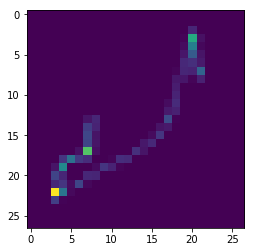

In [27]:
plt.imshow(k)

In [16]:
edgetaper_alpha_torch(k_torch,a_torch.shape[-2:]).sh

2.38 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%timeit tmp = edgetaper_torch(a_torch,k_torch,n_tapers=1);

46 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%timeit tmp2 = edgetaper(a,k,n_tapers=1);

7.22 ms ± 954 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


torch.Size([1, 3, 700, 924])

In [18]:
%timeit pad_for_kernel_torch(a_torch,k_torch)

11.3 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
edgetaper(pad_for_kernel(a,k,'edge'),k).shape

(273, 273)

In [8]:
edgetaper_torch(pad_for_kernel_torch(a_torch,k_torch),k_torch).shape

torch.Size([1, 1, 273, 273])

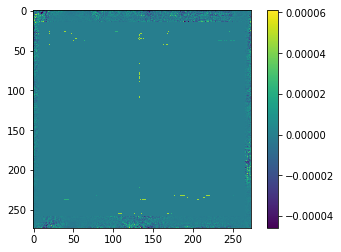

In [11]:
plt.imshow(torch.FloatTensor(edgetaper(pad_for_kernel(a,k,'edge'),k)) - edgetaper_torch(pad_for_kernel_torch(a_torch,k_torch),k_torch)[0,0,:,:])
plt.colorbar()